<a href="https://colab.research.google.com/github/habbang8838/BDAA_treasure_in_data/blob/main/CJ%EC%A0%9C%EC%9D%BC%EC%A0%9C%EB%8B%B9_%EC%A3%BC%EB%AC%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앞의 코드는 df_id를 만들기 위한 코드로, CJ 아이디별 파일 CSV 파일 업로드하고, 중간에 "# 0. 아이디별로 주문을 파악해보겠습니다." 부분부터 코드 실행해주시면 됩니다!

In [33]:
import pandas as pd

In [34]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# 시각화 과정에서 한글 깨짐 방지!!!!

from matplotlib import font_manager, rc
import matplotlib
import platform
import matplotlib.pyplot as plt

%matplotlib inline 

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family = font_name)
else:
    rc('font',family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus']=False
%matplotlib inline

In [36]:
df = pd.read_excel('CJ제일제당 주문 데이터(전처리).xlsx')

KeyboardInterrupt: 

In [ ]:
df

재구매율은 중요하다

In [ ]:
df['아이디'].nunique()

In [ ]:
len(df)

# 시간대 및 유입채널에 대한 대분류 칼럼을 추가

In [ ]:
df['시간대'] = df['주문접수일시'].dt.hour

In [ ]:
df['시간대 대분류'] = '21 ~ 00'
df.loc[(df['시간대'] >= 0) & (df['시간대'] < 3),'시간대 대분류'] = '00 ~ 03'
df.loc[(df['시간대'] >= 3) & (df['시간대'] < 6),'시간대 대분류'] = '03 ~ 06'
df.loc[(df['시간대'] >= 6) & (df['시간대'] < 9),'시간대 대분류'] = '06 ~ 09'
df.loc[(df['시간대'] >= 9) & (df['시간대'] < 12),'시간대 대분류'] = '09 ~ 12'
df.loc[(df['시간대'] >= 12) & (df['시간대'] < 15),'시간대 대분류'] = '12 ~ 15'
df.loc[(df['시간대'] >= 15) & (df['시간대'] < 18),'시간대 대분류'] = '15 ~ 18'
df.loc[(df['시간대'] >= 18) & (df['시간대'] < 21),'시간대 대분류'] = '18 ~ 21'

# 유입채널을 크게 제가 5가지로 분류해보도록 하겠습니다.

- 1 - 유실 채널 상세, 디폴트 채널 상세로 앱에서 들어 가서 직접 찾는 경우(오리지날 방법)
- 2 - 가격비교 사이트 들어가서 찾은 경우
- 3 - 모바일(카카오톡, 공유하기 등)
- 4 - 검색 기능으로 찾은 경우
- 5 - 기타(롯데ON, 혹은 그 이외의 이벤트 )

In [ ]:
df['유입채널 대분류'] = '기타 및 이벤트 광고'
df.loc[((df['유입채널'] == '유실 채널상세') | (df['유입채널'] == '디폴트 채널상세')), '유입채널 대분류'] = 'CJ 앱/사이트'
df.loc[df['유입채널'].str.contains('가격비교'), '유입채널 대분류'] = '가격비교'
df.loc[df['유입채널'].str.contains('모바일'), '유입채널 대분류'] = '모바일 공유'
df.loc[df['유입채널'].str.contains('검색'), '유입채널 대분류'] = '검색'

In [ ]:
df['유입채널 대분류'].value_counts()

In [ ]:
# id 및 유입채널 별로 분석하기 위해, 데이터프레임에서 필요한 변수 위주로만 남겨놓겠습니다.
df.columns
df = df[['주문접수일시', '주문번호', '유입채널 대분류', '시간대 대분류', '주문월', '아이디', '판매자상품명', '판매가', '표준카테고리']]

In [ ]:
df

# idea : 아이디별로 묶어서 특정 회원의 주문을 분석하도록 하겠습니다.

## 주문 횟수가 1~2회인 회원의 경우 패턴을 파악하기가 어렵기에, 그래도 3회 이상이었던 회원들에 한해서 주문 패턴을 파악하기!

In [ ]:
df['아이디'].value_counts().loc[lambda x: x>= 3]

In [ ]:
df['아이디'].value_counts() >= 3

In [ ]:
df['아이디'].value_counts().loc[lambda x: x>= 3].index

In [ ]:
# 먼저 id가 3회 이상 나온 데이터에 한해서만 저장하도록 할게요!!

df_id = df[df['아이디'] == df['아이디'].value_counts().loc[lambda x: x>= 3].index[0]]
for i in range(1, len(df['아이디'].value_counts().loc[lambda x: x>= 3].index)):
    df_id = df_id.append(df[df['아이디'] == df['아이디'].value_counts().loc[lambda x: x>= 3].index[i]])
df_id.head()

In [ ]:
# 일단 아이디가  *, **, ***, **** 으로만 나타나거나, null 값인 경우는 같은 회원으로 보기 어려워서 삭제하겠습니다.

df_id = df_id[(df_id['아이디'] != '*') & (df_id['아이디'] != '**') & 
                  (df_id['아이디'] != '***') & (df_id['아이디'] != '****') & (df_id['아이디'] != '')]

In [ ]:
len(df_id) # 34710개의 데이터가 들어갔네요...

In [ ]:
df_id.head()

# 자, 이제 최소 주문을 3회 이상했던 친구들의 데이터를 다음과 같이 데이터프레임으로 모아줬습니다.

In [ ]:
df_id

# 0. 아이디별로 주문을 파악해보겠습니다.

In [ ]:
# df_id.to_csv('CJ 아이디별 조회.csv', encoding='utf-8')

# CJ 아이디별 파일 다운받고, 여기서부터 코딩 실행해주세요!!

In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import matplotlib
import platform
import matplotlib.pyplot as plt

%matplotlib inline 

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family = font_name)
else:
    rc('font',family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus']=False
%matplotlib inline

In [38]:
df_id = pd.read_csv('CJ 아이디별 조회.csv')

In [39]:
df_id['주문접수일시'] = pd.to_datetime(df_id['주문접수일시'])

In [40]:
df_id['주문날짜'] = df_id['주문번호']//(10**8)
df_id['주문날짜'].astype(str)
df_id['주문날짜'] = pd.to_datetime(df_id['주문날짜'], format = "%Y%m%d")

In [41]:
df_id_test = df_id.groupby(['아이디']).count()

In [42]:
df_id_cond = df_id_test[df_id_test['주문접수일시'] >= 2]

In [43]:
df_id_cond.sort_values(by='주문접수일시', ascending=False)

,주문접수일시,주문번호,유입채널 대분류,시간대 대분류,주문월,판매자상품명,판매가,표준카테고리,주문날짜
아이디,,,,,,,,,
love****,220,220,220,220,220,220,220,220,220
blue****,196,196,196,196,196,196,196,196,196
csh3718,165,165,165,165,165,165,165,165,165
jung****,135,135,135,135,135,135,135,135,135
yoon****,130,130,130,130,130,130,130,130,130
...,...,...,...,...,...,...,...,...,...
km92****,3,3,3,3,3,3,3,3,3
kma1****,3,3,3,3,3,3,3,3,3
kma1119,3,3,3,3,3,3,3,3,3


In [44]:
df_id_cond[df_id_cond['주문접수일시'] == 220].index

Index(['love****'], dtype='object', name='아이디')

In [45]:
df_mem1 = df_id[df_id['아이디'] == 'love****']

In [46]:
df_mem1

,주문접수일시,주문번호,유입채널 대분류,시간대 대분류,주문월,아이디,판매자상품명,판매가,표준카테고리,주문날짜
0,2022-01-07 06:55:35,2022010712865550,가격비교,06 ~ 09,1,love****,[CJ직배송] CJ 햇반 매일잡곡밥 210g x 24개,36000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-01-07
1,2022-01-07 06:57:53,2022010712865630,가격비교,06 ~ 09,1,love****,[CJ직배송] CJ 햇반 매일잡곡밥 210g x 24개,36000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-01-07
2,2022-01-10 09:36:32,2022011013280040,검색,09 ~ 12,1,love****,CJ 고메 중화짜장 760Gx3개,21530,가공식품 > 면류 > 중화면,2022-01-10
3,2022-01-10 11:56:34,2022011013300450,CJ 앱/사이트,09 ~ 12,1,love****,[CJ직배송]CJ비비고왕교자1.05KG X 2개,19920,냉장/냉동/간편식 > 떡볶이/만두 > 만두,2022-01-10
4,2022-01-10 16:28:22,2022011013337260,가격비교,15 ~ 18,1,love****,[CJ직배송]쉐프솔루션 고기만땅왕교자 1.05KG X3개,20940,냉장/냉동/간편식 > 떡볶이/만두 > 만두,2022-01-10
...,...,...,...,...,...,...,...,...,...,...
215,2022-07-06 03:12:42,2022070618027370,CJ 앱/사이트,03 ~ 06,7,love****,[햇반 솥반 X 서울체크인]햇반 솥반 7종,27000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-07-06
216,2022-07-06 03:12:42,2022070618027370,CJ 앱/사이트,03 ~ 06,7,love****,햇반/쿡반불고기주먹밥500G+햇반/쿡반김치치즈주먹밥500G+햇반/쿡반버터장조림주먹밥...,31000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-07-06
217,2022-07-06 15:59:10,2022070618106970,기타 및 이벤트 광고,15 ~ 18,7,love****,[파티컵증정]고메 순살 후라이드 치킨 550gx3개,27090,냉장/냉동/간편식 > 피자/핫도그/햄버거 > 피자/햄버거,2022-07-06
218,2022-07-06 15:59:10,2022070618106970,기타 및 이벤트 광고,15 ~ 18,7,love****,고메 바삭쫄깃한 탕수육 450gx3개,28340,냉장/냉동/간편식 > 동그랑땡/전/튀김 > 튀김류,2022-07-06


In [47]:
df_mem1['시간대 대분류'].value_counts()

21 ~ 00    50
15 ~ 18    37
00 ~ 03    33
12 ~ 15    26
18 ~ 21    26
09 ~ 12    23
06 ~ 09    16
03 ~ 06     9
Name: 시간대 대분류, dtype: int64

In [48]:
df_mem1['유입채널 대분류'].value_counts()

CJ 앱/사이트       163
가격비교            32
기타 및 이벤트 광고     12
모바일 공유           8
검색               5
Name: 유입채널 대분류, dtype: int64

<AxesSubplot:xlabel='시간대 대분류', ylabel='count'>

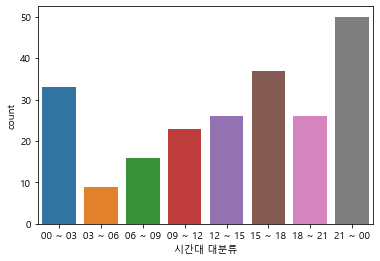

In [49]:
# 위 사용자는 주로 언제 주문을 할까?
sns.countplot(x='시간대 대분류', data=df_mem1, order=['00 ~ 03', '03 ~ 06', '06 ~ 09', '09 ~ 12', '12 ~ 15', '15 ~ 18', '18 ~ 21', '21 ~ 00'])

In [50]:
df_mem1_1 = df_mem1[df_mem1['유입채널 대분류'] == 'CJ 앱/사이트']
# CJ 앱/사이트에서는 언제 홍보하는게 좋을까?

<AxesSubplot:xlabel='시간대 대분류', ylabel='count'>

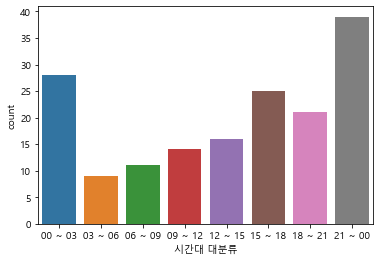

In [51]:
sns.countplot(x='시간대 대분류', data=df_mem1_1, order=['00 ~ 03', '03 ~ 06', '06 ~ 09', '09 ~ 12', '12 ~ 15', '15 ~ 18', '18 ~ 21', '21 ~ 00'])

In [52]:
df_mem1_2 = df_mem1[df_mem1['유입채널 대분류'] == '가격비교']

<AxesSubplot:xlabel='시간대 대분류', ylabel='count'>

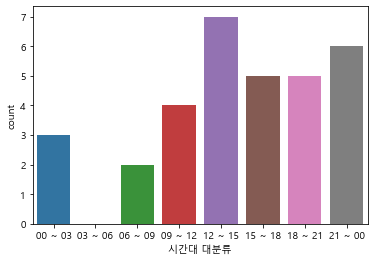

In [53]:
sns.countplot(x='시간대 대분류', data=df_mem1_2, order=['00 ~ 03', '03 ~ 06', '06 ~ 09', '09 ~ 12', '12 ~ 15', '15 ~ 18', '18 ~ 21', '21 ~ 00'])
# 가격비교는 언제 활성화시키는게 좋을까?

### -> 이 회원은 주로 21 ~ 00시, 00 ~ 03시 야간 시간대에 대체로 많이 주문하며, 
### CJ 채널에서 직접 주문은 21 ~ 03시, 가격 비교로서의 주문은 12 ~ 00시에 많음을 알 수 있습니다.

In [54]:
df_mem1_1

,주문접수일시,주문번호,유입채널 대분류,시간대 대분류,주문월,아이디,판매자상품명,판매가,표준카테고리,주문날짜
3,2022-01-10 11:56:34,2022011013300450,CJ 앱/사이트,09 ~ 12,1,love****,[CJ직배송]CJ비비고왕교자1.05KG X 2개,19920,냉장/냉동/간편식 > 떡볶이/만두 > 만두,2022-01-10
6,2022-01-21 10:27:34,2022012114917170,CJ 앱/사이트,09 ~ 12,1,love****,CJ 비비고 사골곰탕 500g x18봉,25000,냉장/냉동/간편식 > 국/탕/찌개 > 국/탕,2022-01-21
7,2022-01-26 16:48:00,2022012615681210,CJ 앱/사이트,15 ~ 18,1,love****,[CJ직배송] 최저가 혜택! 22년 설 선물 스팸 S2호,30550,가공식품 > 통조림/캔 > 캔/통조림선물세트,2022-01-26
9,2022-02-05 18:05:15,2022020516790290,CJ 앱/사이트,18 ~ 21,2,love****,[CJ직배송]CJ 명가김 파래김 4G*16EA X 2개,9960,수산/건어물 > 김/해조류 > 조미김/도시락김,2022-02-05
11,2022-02-08 22:40:48,2022020817414840,CJ 앱/사이트,21 ~ 00,2,love****,CJ 다담 우렁강된장비빔양념 140g x10,13800,가공식품 > 소스/드레싱 > 굴소스/중화요리소스,2022-02-08
...,...,...,...,...,...,...,...,...,...,...
213,2022-07-05 13:38:10,2022070517934160,CJ 앱/사이트,12 ~ 15,7,love****,[CJ직배송]다담 우렁강된장 비빔양념 x10개 + 정통된장찌개양념 x3개,15000,가공식품 > 소스/드레싱 > 기타소스,2022-07-05
214,2022-07-06 03:12:42,2022070618027370,CJ 앱/사이트,03 ~ 06,7,love****,햇반 작은공기/100% 현미밥130g x 36개[선택 1],45000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-07-06
215,2022-07-06 03:12:42,2022070618027370,CJ 앱/사이트,03 ~ 06,7,love****,[햇반 솥반 X 서울체크인]햇반 솥반 7종,27000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-07-06
216,2022-07-06 03:12:42,2022070618027370,CJ 앱/사이트,03 ~ 06,7,love****,햇반/쿡반불고기주먹밥500G+햇반/쿡반김치치즈주먹밥500G+햇반/쿡반버터장조림주먹밥...,31000,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,2022-07-06


In [55]:
df_mem1_1['판매자상품명'].value_counts()

비비고 사골곰탕 500g x18봉                                            22
[Lpoint 1,000P 지급]햇반 작은공기, 100% 현미밥 x 36개 특가 (1,000set 한정)    14
[CJ직배송]포도씨유 900ML X 2개                                        11
비비고 BEST 볶음밥 3종 특가[불고기 비빔밥 + 매콤부추고기볶음밥 + 간장버터장조림볶음밥]           9
비비고 왕교자 1.05KGx4개+비비고 찐만두 168gx1개                              8
                                                              ..
[4개][햇반 솥반 X 서울체크인] 햇반 솥반 흑미밤찰밥 210G x4개                       1
비비고 전복죽 280g X 5개                                              1
[사은품]  해찬들 우리쌀로만든태양초골드고추장 1kg X2개                              1
고메 바삭쫄깃한 탕수육 450gx3개                                           1
햇반 작은공기/100% 현미밥130g x 36개[선택 1]                               1
Name: 판매자상품명, Length: 73, dtype: int64

<AxesSubplot:xlabel='count', ylabel='판매자상품명'>

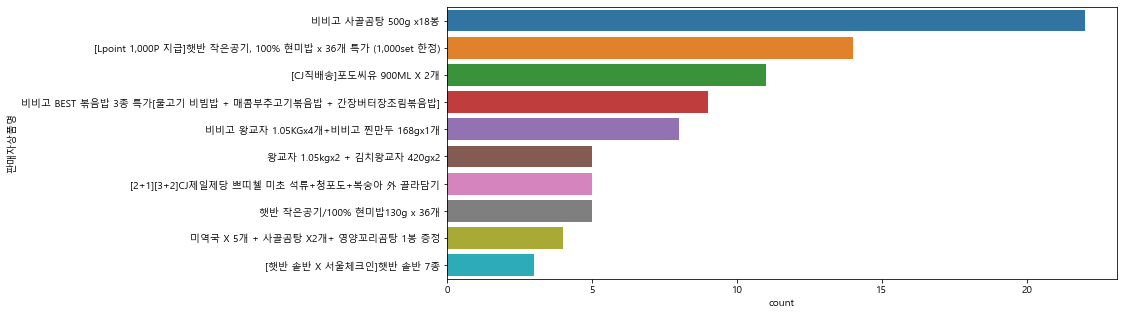

In [56]:
# 상품별로 많이 사는 제품 시각화 -> 곰탕, 즉석밥, 만두, 식용유 등이 과반수를 차지하는 것을 알 수 있다.

df_mem1_1_top10 = df_mem1_1['판매자상품명'].value_counts().head(10).index

plt.figure(figsize=(12, 5))
sns.countplot(y='판매자상품명', data=df_mem1_1, order=[df_mem1_1_top10[i] for i in range(0,10)])

In [57]:
df_mem1_1.groupby(['시간대 대분류','표준카테고리']).count()

주문접수일시  주문번호  유입채널 대분류  주문월  아이디  판매자상품명  \
시간대 대분류 표준카테고리                                                                 
00 ~ 03 가공식품 > 면류 > 기타면류                 1     1         1    1    1       1   
        가공식품 > 식용유/오일 > 식용유/오일선물세트       2     2         2    2    2       2   
        가공식품 > 식용유/오일 > 카놀라유             1     1         1    1    1       1   
        과자/간식 > 캔디/껌/캐러멜 > 젤리/푸딩         1     1         1    1    1       1   
        김치/반찬 > 김치 > 포기김치                1     1         1    1    1       1   
...                                    ...   ...       ...  ...  ...     ...   
21 ~ 00 냉장/냉동/간편식 > 떡볶이/만두 > 만두          9     9         9    9    9       9   
        냉장/냉동/간편식 > 즉석밥/죽/스프 > 볶음밥       1     1         1    1    1       1   
        냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥       5     5         5    5    5       5   
        정육/계란 > 양념육 > 기타양념육              1     1         1    1    1       1   
        커피/생수/음료 > 주스/과즙음료 > 과일음료        1     1         1    1    1       1   

                                    판매가  주문날짜  
시간대 대분류 표준카테고리                                 
00 ~ 03 가공식품 > 면류 > 기타면류              1     1  
        가공식품 > 식용유/오일 > 식용유/오일선물세트    2     2  
        가공식품 > 식용유/오일 > 카놀라유          1     1  
        과자/간식 > 캔디/껌/캐러멜 > 젤리/푸딩      1     1  
        김치/반찬 > 김치 > 포기김치             1     1  
...                                 ...   ...  
21 ~ 00 냉장/냉동/간편식 > 떡볶이/만두 > 만두       9     9  
        냉장/냉동/간편식 > 즉석밥/죽/스프 > 볶음밥    1     1  
        냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥    5     5  
        정육/계란 > 양념육 > 기타양념육           1     1  
        커피/생수/음료 > 주스/과즙음료 > 과일음료     1     1  

[72 rows x 8 columns]

<AxesSubplot:xlabel='count', ylabel='표준카테고리'>

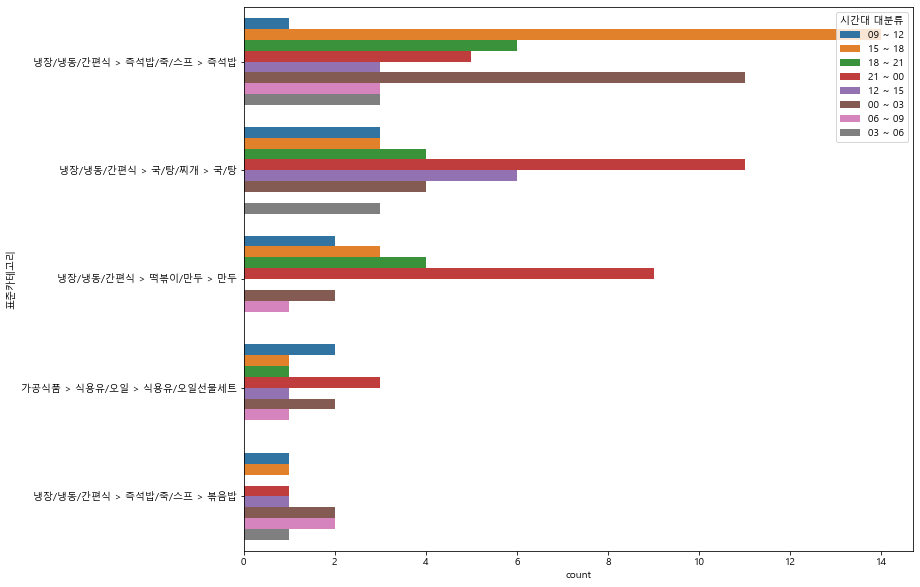

In [58]:
# 카테고리별로 많이 사는 제품 시각화
# 같은 상품인데도 제품별로 이름이 조금씩 다르기 때문에, 한 번 더 확인해줍니다.
# ex. 앞에 '[2+1]'이나 '[CJ직배송]'', 내지는 '*1개, *3개' 처럼 같은 상품인데도 상품명이 다르기 때문에 카테고리로 묶어주겠습니다.

df_mem1_1_top_category = df_mem1_1['표준카테고리'].value_counts().head(5).index
plt.figure(figsize=(12, 10))
sns.countplot(y='표준카테고리', data=df_mem1_1, order=[df_mem1_1_top_category[i] for i in range(0,5)], hue='시간대 대분류')

<AxesSubplot:xlabel='count', ylabel='판매자상품명'>

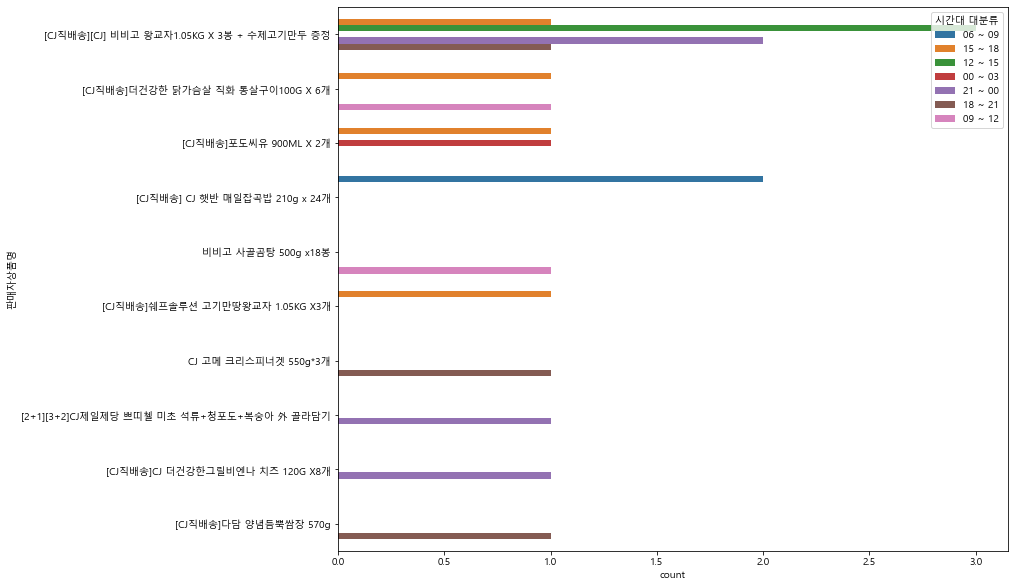

In [59]:
df_mem1_2_top10 = df_mem1_2['판매자상품명'].value_counts().head(10).index

plt.figure(figsize=(12, 10))
sns.countplot(y='판매자상품명', data=df_mem1_2, order=[df_mem1_2_top10[i] for i in range(0,10)], hue='시간대 대분류')

* 이 회원은 주로 즉석밥(볶음밥), 국/탕(곰탕), 만두(교자), 식용유(포도씨유)를 구매하는 것을 알 수 있으며,
* 주문량이 많은 21 ~ 00 시에 국/탕을 살때 만두를 함께 구매하는 것으로도 볼 수 있을 것 같습니다.
* 그가 주로 주문하는 제품(혹은 같은 카테고리 내 판매량 많은 제품)이 할인 기간이거나,
* 국/탕과 만두를 묶음으로 판매하는 할인 이벤트를 할 때
* CJ 앱/사이트에서는 21 ~ 03시에,
* 가격비교 사이트에서는 12 ~ 00시 사이에 광고를 활성화하여 재구매를 유도하면 좋을 것 같습니다.

# 1. 아이디와 카테고리로 그룹화하여 개인별 구매 패턴을 확인해보겠습니다.

In [60]:
df_id_test1 = df_id.groupby(['아이디', '표준카테고리']).count()

In [61]:
# 그래도 2번 이상 특정 회원이 특정 상품을 구매한 데이터들에 대하여 패턴을 찾는 것이 중요할 것이라고 생각하였습니다.
# 변수별로 na 값이 아니고서야, count수가 모두 같기에, 대표하는 변수 '주문접수 일시'로 검색하였습니다.

df_id_cond1 = df_id_test1[df_id_test1['주문접수일시'] >= 2]

In [62]:
df_id_cond1

,,주문접수일시,주문번호,유입채널 대분류,시간대 대분류,주문월,판매자상품명,판매가,주문날짜
아이디,표준카테고리,,,,,,,,
-_-i****,냉장/냉동/간편식 > 떡볶이/만두 > 만두,14,14,14,14,14,14,14,14
-_-ing,냉장/냉동/간편식 > 떡볶이/만두 > 만두,7,7,7,7,7,7,7,7
0107****,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,15,15,15,15,15,15,15,15
0109eun,냉장/냉동/간편식 > 돈가스/고로케/너겟 > 너겟,2,2,2,2,2,2,2,2
0111125,냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...
zzqz****,냉장/냉동/간편식 > 떡볶이/만두 > 만두,2,2,2,2,2,2,2,2
zzx1832aa,냉장/냉동/간편식 > 국/탕/찌개 > 국/탕,3,3,3,3,3,3,3,3
zzzz****,가공식품 > 식용유/오일 > 식용유/오일선물세트,2,2,2,2,2,2,2,2


In [63]:
df_id_cond1.sort_values(by='주문접수일시', ascending=False)

주문접수일시  주문번호  유입채널 대분류  시간대 대분류  \
아이디          표준카테고리                                                           
csh3718      냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥        165   165       165      165   
jackal1104   냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥        122   122       122      122   
urimiracle   냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥         91    91        91       91   
dpalwl12     냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥         88    88        88       88   
yoon****     냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥         79    79        79       79   
...                                            ...   ...       ...      ...   
kysw****     김치/반찬 > 김치 > 포기김치                   2     2         2        2   
kyun****     가공식품 > 장류 > 된장/쌈장/청국장               2     2         2        2   
             냉장/냉동/간편식 > 햄/소시지/베이컨 > 햄/소시지       2     2         2        2   
chanheumchol 냉장/냉동/간편식 > 국/탕/찌개 > 국/탕            2     2         2        2   
ko11****     가공식품 > 식용유/오일 > 식용유/오일선물세트          2     2         2        2   

                                            주문월  판매자상품명  판매가  주문날짜  
아이디          표준카테고리                                                 
csh3718      냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥     165     165  165   165  
jackal1104   냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥     122     122  122   122  
urimiracle   냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥      91      91   91    91  
dpalwl12     냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥      88      88   88    88  
yoon****     냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥      79      79   79    79  
...                                         ...     ...  ...   ...  
kysw****     김치/반찬 > 김치 > 포기김치                2       2    2     2  
kyun****     가공식품 > 장류 > 된장/쌈장/청국장            2       2    2     2  
             냉장/냉동/간편식 > 햄/소시지/베이컨 > 햄/소시지    2       2    2     2  
chanheumchol 냉장/냉동/간편식 > 국/탕/찌개 > 국/탕         2       2    2     2  
ko11****     가공식품 > 식용유/오일 > 식용유/오일선물세트       2       2    2     2  

[6513 rows x 8 columns]

In [69]:
# (아이디, 상품명)을 카운트하여, 예시로 urimiracle님의 데이터를 조사해보겠습니다.

df_id_cond1[df_id_cond1['주문접수일시'] == 91].index

MultiIndex([('urimiracle', '냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥')],
           names=['아이디', '표준카테고리'])

In [70]:
df_uri = df_id[(df_id['아이디'] == 'urimiracle') & (df_id['표준카테고리'] == '냉장/냉동/간편식 > 즉석밥/죽/스프 > 즉석밥')]

In [71]:
df_uri1 = df_id[(df_id['아이디'] == 'urimiracle')]

df_uri1['판매자상품명'].value_counts()

[CJ직배송] New 햇반 210g*3입X 8개(총24개)    34
[CJ직배송]햇반 발아현미밥 210gX36개[1박스]       28
[CJ직배송]햇반 매일찰잡곡밥 210G*3 X6개         10
[CJ직배송]햇반 100%현미로 지은밥 130G x36개      9
햇반 100% 현미로 지은밥 130G*3 x12           4
[CJ직배송]햇반 발아현미밥210g*3EA X6개          3
CJ 햇반 큰공기 300G x18                   2
[CJ직배송]햇반 매일콩잡곡밥 210G*3EA X6개        1
Name: 판매자상품명, dtype: int64

### urimiracle님의 경우, 가격 비교를 통해서 주로 06~18시에 즉석밥 종류를 주문하는구나!!, -> 패턴 파악

In [72]:
df_uri['유입채널 대분류'].value_counts()

가격비교        83
CJ 앱/사이트     6
검색           2
Name: 유입채널 대분류, dtype: int64

In [73]:
df_uri['시간대 대분류'].value_counts()

06 ~ 09    36
09 ~ 12    27
12 ~ 15    16
15 ~ 18    12
Name: 시간대 대분류, dtype: int64

In [74]:
# 판매가는 대략 어느 정도에서 형성하거나, 할인하는 것이 좋을까?

df_uri.groupby(['판매자상품명', '판매가']).count()

주문접수일시  주문번호  유입채널 대분류  시간대 대분류  주문월  \
판매자상품명                           판매가                                           
CJ 햇반 큰공기 300G x18               38800       2     2         2        2    2   
[CJ직배송] New 햇반 210g*3입X 8개(총24개) 33000      34    34        34       34   34   
[CJ직배송]햇반 100%현미로 지은밥 130G x36개  43200       5     5         5        5    5   
                                 45000       1     1         1        1    1   
                                 60000       3     3         3        3    3   
[CJ직배송]햇반 매일찰잡곡밥 210G*3 X6개      26920      10    10        10       10   10   
[CJ직배송]햇반 매일콩잡곡밥 210G*3EA X6개    26920       1     1         1        1    1   
[CJ직배송]햇반 발아현미밥 210gX36개[1박스]    47800      28    28        28       28   28   
[CJ직배송]햇반 발아현미밥210g*3EA X6개      28770       3     3         3        3    3   
햇반 100% 현미로 지은밥 130G*3 x12       53000       4     4         4        4    4   

                                        아이디  표준카테고리  주문날짜  
판매자상품명                           판매가                       
CJ 햇반 큰공기 300G x18               38800    2       2     2  
[CJ직배송] New 햇반 210g*3입X 8개(총24개) 33000   34      34    34  
[CJ직배송]햇반 100%현미로 지은밥 130G x36개  43200    5       5     5  
                                 45000    1       1     1  
                                 60000    3       3     3  
[CJ직배송]햇반 매일찰잡곡밥 210G*3 X6개      26920   10      10    10  
[CJ직배송]햇반 매일콩잡곡밥 210G*3EA X6개    26920    1       1     1  
[CJ직배송]햇반 발아현미밥 210gX36개[1박스]    47800   28      28    28  
[CJ직배송]햇반 발아현미밥210g*3EA X6개      28770    3       3     3  
햇반 100% 현미로 지은밥 130G*3 x12       53000    4       4     4

가격비교로 구매한 상품 중 많이 산 상품을 파악해서 가격대를 모니터링한다.